In [ ]:
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install opencv

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### Funções Utilitárias

In [7]:
def load_images_from_directory(directory, img_size=(50, 50)):
    """
    Carrega e redimensiona imagens de um diretório.
    Args:
        directory (str): Caminho do diretório.
        img_size (tuple): Tamanho para redimensionamento das imagens.
    Returns:
        images (list): Lista de imagens em escala de cinza redimensionadas.
        labels (list): Lista de rótulos correspondentes.
    """
    images = []
    labels = []
    classes = sorted(os.listdir(directory))  # Cada subdiretório é uma classe
    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                img_path = os.path.join(class_path, file_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega em escala de cinza
                if img is not None:
                    img_resized = cv2.resize(img, img_size)
                    images.append(img_resized.flatten())  # Achatar imagem em vetor
                    labels.append(label_idx)
    return np.array(images), np.array(labels)


In [8]:
def normalize_data(images):
    return images / 255.0

In [9]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]


#### Definição do Modelo Perceptron

In [15]:
def step_function(x):
    return np.where(x >= 0, 1, 0)

class Perceptron:
    def __init__(self, input_size, num_classes):
        self.weights = np.random.randn(input_size, num_classes) * 0.01
        self.bias = np.zeros(num_classes)

    def train(self, X, y, epochs=10, lr=0.1):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                output = step_function(np.dot(X[i], self.weights) + self.bias)
                error = y[i] - output
                self.weights += lr * np.outer(X[i], error)
                self.bias += lr * error

    def predict(self, X):
        return step_function(np.dot(X, self.weights) + self.bias)


#### Funções de Avaliação
Dividir dados

In [16]:
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

Avaliar modelo

In [17]:
def evaluate_model(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    sensitivity = np.mean((y_true == 1) & (y_pred == 1)) / np.mean(y_true == 1)
    specificity = np.mean((y_true == 0) & (y_pred == 0)) / np.mean(y_true == 0)
    return accuracy, sensitivity, specificity

Plotar matriz de confusão

In [18]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    confusion = np.zeros((len(class_names), len(class_names)), dtype=int)
    for t, p in zip(y_true, y_pred):
        confusion[t, p] += 1
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#### Configuração e Pré-processamento

In [30]:
# Configuração do diretório e tamanhos
data_dir = r"RecFac"
img_size = (50, 50)

# Carregar e processar as imagens
images, labels = load_images_from_directory(data_dir, img_size=img_size)
images = normalize_data(images)
num_classes = len(set(labels))
labels_one_hot = one_hot_encode(labels, num_classes)

#### Divisão de Dados

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot)

#### Treinamento do Perceptron

In [29]:
perceptron = Perceptron(input_size=images.shape[1], num_classes=num_classes)
perceptron.train(X_train, y_train, epochs=10, lr=0.1)

#### Avaliação do Modelo

In [31]:
y_pred_train = np.argmax(perceptron.predict(X_train), axis=1)
y_pred_test = np.argmax(perceptron.predict(X_test), axis=1)

y_true_train = np.argmax(y_train, axis=1)
y_true_test = np.argmax(y_test, axis=1)

train_accuracy, train_sensitivity, train_specificity = evaluate_model(y_true_train, y_pred_train)
test_accuracy, test_sensitivity, test_specificity = evaluate_model(y_true_test, y_pred_test)

In [32]:
# Exibir resultados
print(
f'''Treino 
    Acurácia: {train_accuracy}, 
    Sensibilidade: {train_sensitivity}, 
    Especificidade: {train_specificity}''')
print(
f'''Teste 
    Acurácia: {test_accuracy}, 
    Sensibilidade: {test_sensitivity}, 
    Especificidade: {test_specificity}''')

Treino 
    Acurácia: 1.0, 
    Sensibilidade: 1.0, 
    Especificidade: 1.0
Teste 
    Acurácia: 0.9140625, 
    Sensibilidade: 0.8888888888888888, 
    Especificidade: 1.0


#### Visualizar Resultados

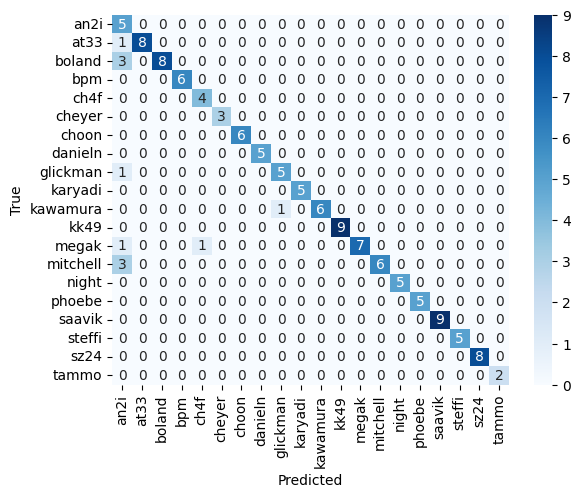

In [33]:
class_names = sorted(os.listdir(data_dir))
plot_confusion_matrix(y_true_test, y_pred_test, class_names)